### LangGraph Tool Routing  

#### Overview  
This script demonstrates how to use **LangGraph** to build a structured workflow that can invoke tools dynamically. The workflow includes:  

- **LLM-Based Chat**: Uses `ChatGroq` to process and respond to user messages.  
- **Tool Invocation**: Supports basic mathematical operations (addition and multiplication).  
- **State Graph**: Implements a structured execution flow using `StateGraph` for dynamic tool execution.  

#### Features  
- Initializes a chat history with predefined messages.  
- Binds math functions (`add_numbers`, `multiply_numbers`) as tools for LLM-based execution.  
- Constructs a **state graph** that routes tool calls dynamically based on conditions.  
- Generates a **visual representation** of the workflow graph.  

#### Tool Routing Logic  
1. **User Query Processing**  
   - The LLM receives a user query and determines if a tool needs to be invoked.  
   
2. **Tool Invocation Handling**  
   - If the query involves addition or multiplication, the corresponding function is executed.  
   - If the query contains an unsupported operation (e.g., division), it is not handled by the tools.  

3. **Routing in the State Graph**  
   - The workflow starts at `START`.  
   - It moves to `invoke_tool_function`, where the LLM decides if a tool call is needed.  
   - If a tool call is detected, execution moves to the **Tools Node**.  
   - If no valid tool is found, the execution **ends without tool invocation**.  

In [12]:
import os
from dotenv import load_dotenv
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, AnyMessage
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
from IPython.display import Image, display


In [13]:
# Load environment variables from a .env file
load_dotenv()

# Set API key for Groq model
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

In [14]:
# Step 1: Define a chat history using messages
chat_history = [
    AIMessage(content=f"So you said you were researching ocean mammals?", name="Model"),
    HumanMessage(content=f"Yes, that's right.",name="John"),
    AIMessage(content=f"Great, what would you like to learn about.", name="Model"),
    HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="John")
]

# Print chat history for verification
for messages in chat_history:
    messages.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: John

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: John

I want to learn about the best place to see Orcas in the US.


In [15]:
# Step 2: Initialize the Groq LLM model
llm = ChatGroq(model='qwen-2.5-32b')

# Generate AI response based on the chat history
ai_response = llm.invoke(chat_history)
print("AI Response:", ai_response)

AI Response: content="Seeing orcas (also known as killer whales) in the United States can be a thrilling experience. One of the best places to see them is in the Pacific Northwest, particularly around the waters of Washington State. Here are a few specific spots:\n\n1. **San Juan Islands, Washington**: This is one of the most famous places to spot orcas, especially during summer months. The waters around San Juan Island are part of the Salish Sea, which is a critical habitat for the Southern Resident Killer Whales, a group of orcas that has been the subject of much conservation effort due to their endangered status. You can join a whale-watching tour from various spots like Friday Harbor.\n\n2. **Olympic Coast National Marine Sanctuary, Washington**: This area off the coast of Washington State is also a good place to see orcas, particularly Northern Resident orcas and transient orcas that travel in smaller pods. These waters are rich in fish, which attract orcas and other marine life.\

In [16]:
# Step 3: Define simple math functions for tool invocation
def add_numbers(a:int, b:int) -> int :
    """Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a+b

def multiply_numbers(a:int, b:int) -> int :
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a*b

In [17]:
# Bind tools to the LLM model
llm_with_tools = llm.bind_tools([add_numbers, multiply_numbers])

In [18]:
# Step 4: Invoke the model with a tool call (e.g., for math operations)
tool_response = llm_with_tools.invoke([
    HumanMessage(content=f"What is 2 plus by 3", name="John")
])

# Print the tool response
print("Tool Response:", tool_response)
print("Tool Calls:", tool_response.tool_calls)

Tool Response: content='' additional_kwargs={'tool_calls': [{'id': 'call_j657', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'add_numbers'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 274, 'total_tokens': 300, 'completion_time': 0.13, 'prompt_time': 0.017550817, 'queue_time': 0.090397344, 'total_time': 0.147550817}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_c527211fd1', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-eb61360b-c115-4a07-9934-5bfa2e7cfbd8-0' tool_calls=[{'name': 'add_numbers', 'args': {'a': 2, 'b': 3}, 'id': 'call_j657', 'type': 'tool_call'}] usage_metadata={'input_tokens': 274, 'output_tokens': 26, 'total_tokens': 300}
Tool Calls: [{'name': 'add_numbers', 'args': {'a': 2, 'b': 3}, 'id': 'call_j657', 'type': 'tool_call'}]


In [19]:
# Step 5: Define a message state type for handling messages within the graph
class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [20]:
# Step 6: Define a function to call tools within the state graph
def invoke_tool_function(state: MessageState):
    """Processes messages and invokes appropriate tools if needed."""
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

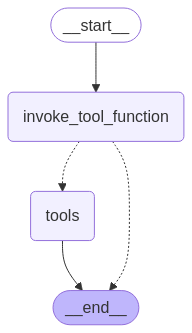

In [21]:

# Step 7: Build a state graph for managing tool calls
workflow_builder = StateGraph(MessageState)

# Add nodes to the graph
workflow_builder.add_node("invoke_tool_function", invoke_tool_function)
workflow_builder.add_node("tools", ToolNode([add_numbers, multiply_numbers]))

# Define graph execution flow
workflow_builder.add_edge(START, "invoke_tool_function")
workflow_builder.add_conditional_edges("invoke_tool_function", tools_condition)
workflow_builder.add_edge("tools", END)

# Compile the graph
workflow_graph = workflow_builder.compile()

# Display the graph structure
display(Image(workflow_graph.get_graph().draw_mermaid_png()))

In [24]:
# Step 8: Invoke the graph with a user query
execution_result = workflow_graph.invoke({
    "messages": HumanMessage(content="What is 2 multiplied by 2? Add 4 to the result. Divide the final result by 2")
})

In [25]:
# Print the messages from the execution result
for message in execution_result["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 multiplied by 2? Add 4 to the result. Divide the final result by 2
================================== Ai Message ==================================
Tool Calls:
  multiply_numbers (call_9pec)
 Call ID: call_9pec
  Args:
    a: 2
    b: 2
  add_numbers (call_xqqk)
 Call ID: call_xqqk
  Args:
    a: 4
    b: 4
  divide_numbers (call_z25b)
 Call ID: call_z25b
  Args:
    a: 8
    b: 2
================================= Tool Message =================================
Name: multiply_numbers

4
================================= Tool Message =================================
Name: add_numbers

8
================================= Tool Message =================================
Name: divide_numbers

Error: divide_numbers is not a valid tool, try one of [add_numbers, multiply_numbers].
